In [1]:
from calciumflexanalysis import calcium_flex as cal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
wells = {6:(2, 3), 12:(3, 4), 24:(4, 6), 48:(6, 8), 96:(8, 12), 384:(16, 24)}
size = 96

In [3]:
# text file to be read in (raw file from machine)
datafile = '291019 TPC4sYFP2 EA 30 nM act IBP74 inhib 3 nM to 3 uM.txt' 

# plate map csv file updated by user (either the 'short' or 'long' template)
mapcsv = 'EA 30 nM act IBP74 3nM to 3 uM.csv' 

# insert the 2 files into the 'CaFlexAnalysis' class
plate3 = cal.CaFlexAnalysis(raw_data = datafile, plate_map_file = mapcsv, data_type = 'new')

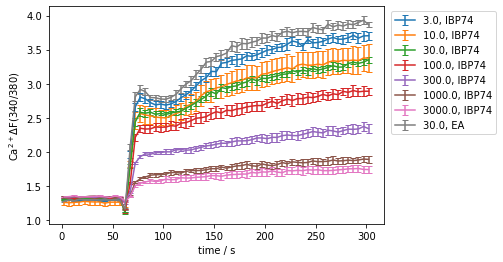

In [4]:
platemap = plate3.plate_map
grouplist = ['Protein','Type', 'Compound','Concentration']

groupdct = {}
for key, val in plate3.processed_data['ratio'].items():
    mapped = platemap.join(val)
    group = mapped[mapped.Valid == True].groupby(grouplist)[val.columns]
    # update dictionary
    groupdct[key] = group
    
# plot series for each condition and control
for i in range(len(groupdct['time'].mean())):
    plt.errorbar(groupdct['time'].mean().iloc[i], groupdct['data'].mean().iloc[i], yerr=groupdct['data'].sem().iloc[i], 
                 capsize = 3, 
                 label = "{}, {}".format(list(groupdct['data'].mean().index.get_level_values('Concentration'))[i], 
                                        list(groupdct['data'].mean().index.get_level_values('Compound'))[i])) 
    # add label function that concatenates conc w/ the correct units 
    plt.legend(loc = "upper right", bbox_to_anchor = (1.35, 1.0))
    plt.xlabel("time / s")
    plt.ylabel("$\mathrm{Ca^{2+} \Delta F(340/380)}$")
plt.show()

Baseline correction (improved)

In [5]:
time_cut = 55
data_source = plate3.processed_data['ratio']
# convert to numpy arrays
time = data_source['time'].to_numpy()
data = data_source['data'].to_numpy()
data
# create mask from mean time values
time_filter = np.nanmean(time,axis=0)<time_cut
# # average over these times
baseline = np.mean(data[:,time_filter],axis=1)
# add dimension to enable broadcasting
baseline = np.expand_dims(baseline, axis=1)
# rewrite values back to dataframes
plate3.processed_data['baseline_corrected'] = {}
data_source = plate3.processed_data['baseline_corrected']['data'] = pd.DataFrame(data-baseline, index = data_source['data'].index)
data_source = plate3.processed_data['baseline_corrected']['time'] = data_source = plate3.processed_data['ratio']['time']



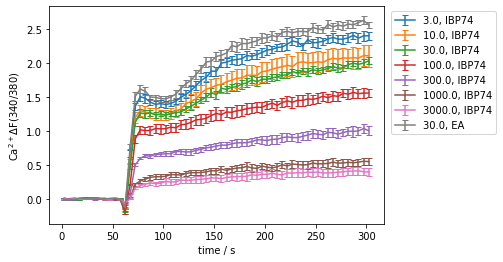

In [6]:
platemap = plate3.plate_map
grouplist = ['Protein','Type', 'Compound','Concentration']

groupdct = {}
for key, val in plate3.processed_data['baseline_corrected'].items():
    mapped = platemap.join(val)
    group = mapped[mapped.Valid == True].groupby(grouplist)[val.columns]
    # update dictionary
    groupdct[key] = group
    
# plot series for each condition and control
for i in range(len(groupdct['time'].mean())):
    plt.errorbar(groupdct['time'].mean().iloc[i], groupdct['data'].mean().iloc[i], yerr=groupdct['data'].sem().iloc[i], 
                 capsize = 3, 
                 label = "{}, {}".format(list(groupdct['data'].mean().index.get_level_values('Concentration'))[i], 
                                        list(groupdct['data'].mean().index.get_level_values('Compound'))[i])) 
    # add label function that concatenates conc w/ the correct units 
    plt.legend(loc = "upper right", bbox_to_anchor = (1.35, 1.0))
    plt.xlabel("time / s")
    plt.ylabel("$\mathrm{Ca^{2+} \Delta F(340/380)}$")
plt.show()

Amplitude gradient calculations

In [33]:
# filter for valid wells
valid_filter = plate3.plate_map.Valid == True

# add opposite time filter to extract data after injection
time_cut = 55
data_source = plate3.processed_data['ratio']

# convert to numpy arrays
time = data_source['time'][valid_filter].to_numpy()
data = data_source['data'][valid_filter].to_numpy()
# create mask from mean time values
post_inject_filter = np.nanmean(time,axis=0) > time_cut

# get absolute gradient for each well along series
gradient = abs(np.gradient(data[:,post_inject_filter], axis = 1))

gradient_dict = {}

# mean gradient every ten measurements
for i in range(gradient.shape[1]-10):
    
    # average of average gradients for every ten measurements post injection
    mean_gradient = np.nanmean(np.mean(gradient[:, i:(i+10)], axis=1), axis = 0)
    gradient_dict[(i), (i+10)] = mean_gradient

# get minimum gradient index window
min_gradient = (min(gradient_dict, key = gradient_dict.get))


amp = (plate3.processed_data['ratio']['data'].iloc[:, min_gradient[0]:min_gradient[1]]).to_numpy()
amp_mean = np.mean(amp, axis = 1)
min_gradient


(35, 45)

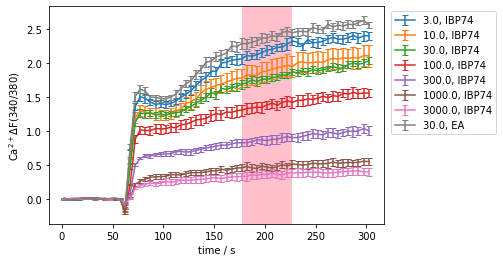

In [34]:
# x min and x max for axvspan 
xmin = plate3.processed_data['baseline_corrected']['time'].loc[:, min_gradient[0]].mean()
xmax = plate3.processed_data['baseline_corrected']['time'].loc[:, min_gradient[1]].mean()


platemap = plate3.plate_map
grouplist = ['Protein','Type', 'Compound','Concentration']

groupdct = {}
for key, val in plate3.processed_data['baseline_corrected'].items():
    mapped = platemap.join(val)
    group = mapped[mapped.Valid == True].groupby(grouplist)[val.columns]
    # update dictionary
    groupdct[key] = group
    
# plot series for each condition and control
for i in range(len(groupdct['time'].mean())):
    plt.errorbar(groupdct['time'].mean().iloc[i], groupdct['data'].mean().iloc[i], yerr=groupdct['data'].sem().iloc[i], 
                 capsize = 3, 
                 label = "{}, {}".format(list(groupdct['data'].mean().index.get_level_values('Concentration'))[i], 
                                        list(groupdct['data'].mean().index.get_level_values('Compound'))[i])) 
    # add label function that concatenates conc w/ the correct units 
    plt.legend(loc = "upper right", bbox_to_anchor = (1.35, 1.0))
    plt.xlabel("time / s")
    plt.ylabel("$\mathrm{Ca^{2+} \Delta F(340/380)}$")
    plt.axvspan(xmin, xmax, facecolor = 'pink', alpha = 0.5)
plt.show()


In [9]:
# update platemap with response amplitude
plate3.plate_map['Response Amplitude'] = amp_mean
plate3.plate_map

,Well ID,Type,Contents,Compound,Protein,Concentration,Concentration Units,Row,Column,Valid,Response Amplitude
Well ID,,,,,,,,,,,
A1,A1,control,EA+DMSO,EA,TRPC5,30.0,nM,A,1,True,2.563573
A2,A2,control,EA+DMSO,EA,TRPC5,30.0,nM,A,2,True,2.503818
A3,A3,control,EA+DMSO,EA,TRPC5,30.0,nM,A,3,True,2.149538
A4,A4,control,EA+DMSO,EA,TRPC5,30.0,nM,A,4,True,2.242397
A5,A5,control,EA+DMSO,EA,TRPC5,30.0,nM,A,5,True,2.341909
...,...,...,...,...,...,...,...,...,...,...,...
H8,H8,empty,NaN,NaN,NaN,NaN,NaN,H,8,True,NaN
H9,H9,empty,NaN,NaN,NaN,NaN,NaN,H,9,True,NaN
H10,H10,empty,NaN,NaN,NaN,NaN,NaN,H,10,True,NaN


In [10]:
# mean response amplitude for each condition
group = plate3.plate_map[plate3.plate_map.Valid == True] 
group.drop(['Valid', 'Column'], axis = 1, inplace = True)
mean_response_amp = group.groupby(grouplist).mean()
mean_response_amp

Response Amplitude
Protein Type     Compound Concentration                    
TRPC5   compound IBP74    3.0                      2.173642
                          10.0                     1.878827
                          30.0                     1.765792
                          100.0                    1.372975
                          300.0                    0.867001
                          1000.0                   0.470352
                          3000.0                   0.355654
        control  EA       30.0                     2.370238

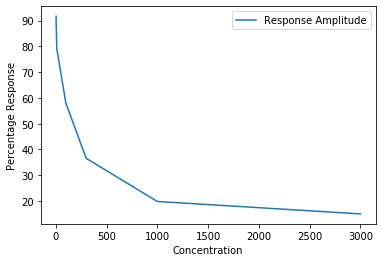

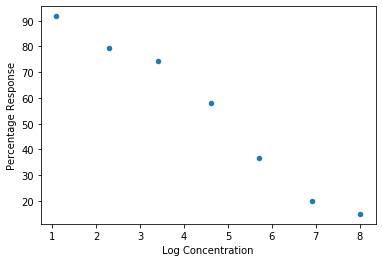

In [12]:
# percentage response

# some crazy slicing to get the control amplitude
control_amp = float(mean_response_amp[mean_response_amp.index.isin(['control'], level = 'Type')]['Response Amplitude'])
perc_response = (mean_response_amp   / control_amp)*100
perc_response.reset_index(inplace = True)
perc_response = perc_response[perc_response['Type'] != "control"] # remove 'control amplitude (=1) '
perc_response['Log Concentration'] = np.log(perc_response['Concentration'])
ax1 = perc_response.plot(x = 'Concentration', y = 'Response Amplitude')
ax2 = perc_response.plot(x = 'Log Concentration', y = 'Response Amplitude', kind = 'scatter')
ax1.set_ylabel('Percentage Response')
ax2.set_ylabel('Percentage Response')

plt.show()